In [4]:
import csv
import os
import sys
import pickle
import numpy as np
import math
sys.path.insert(0, '../')
from model import model1
from sklearn.metrics import roc_curve, auc

In [5]:
data = []
with open('../data/val1/test.csv') as data_file:
    for line in data_file:
        data += line,

In [6]:
with open('../data/val1/M.pickle', 'rb') as handle:
    M = pickle.load(handle)

In [7]:
with open('../data/val1/users_dict.pickle', 'rb') as handle:
    users = pickle.load(handle)
with open('../data/val1/songs_dict.pickle', 'rb') as handle:
    songs = pickle.load(handle)

In [8]:
with open('../data/val1/song_to_singer.pickle', 'rb') as handle:
    song_to_singer = pickle.load(handle)
with open('../data/val1/user_to_singer.pickle', 'rb') as handle:
    user_to_singer = pickle.load(handle)

In [ ]:
def latent_vairable(user_id, M, k, W, V, alpha, lambda1, b_u, b_m, b):
    #init
    for music in table[user_id]:
        r = M[user_id][music]
        error = (rating[music] - \
                 np.dot(W[music], V[:,user_id]) - b_u[user_id] - b_m[music] - b)
#         print np.dot(W[music], V[:,user_id])
#         print b_u[user_id], b_m[music], b
        V[:,user_id] += alpha * (error * W[music] - lambda1 * V[:,user_id])
        W[music] += alpha * (error * V[:,user_id] - lambda1 * W[music])
        b += alpha * error
        b_u[user_id] += alpha * ( error - lambda1 * b_u[user_id])
        b_m[music] += alpha * ( error - lambda1 * b_m[music])

        if math.isnan(error):
            break

In [132]:
b_u, b_m = np.zeros(len(users)), np.zeros(len(songs))
for user in table:
    b_u[user] = float(len(table[user])) / len(users)
    for music in table[user]:
        b_m[music] += 1
b_m = b_m / float(len(users))

In [115]:
real_y = [int(x.split(',')[-1].strip('\r\n')) for x in data]
print real_y[:5]

[1, 0, 0, 1, 0]


In [ ]:
def MF_model_pred(x, users, songs, b_u, b_m, W, V, b):
    x = x.split(',')
    user_id, music_id = users.get(x[1], -1), songs.get(x[2], -1)
    interaction = np.dot(W[music], V[:,user_id]) if user_id != -1 and music_id != -1 \
                    else 0
    pred = b + b_u[user_id] + b_m[music_id] + interaction 
    return max(min(pred, 1), 0)
    #return 1 if pred >= 0.5 else 0
def latent_vairable_model(user_id, table, k, W, V, alpha, lambda1, b_u, b_m, b):
    error = 0
    while user_id < len(users):
        error += latent_vairable(user_id, table, k, W, V, alpha, lambda1, b_u, b_m, b)
        if math.isnan(error):
            break
        user_id = user_id + 1
    return error
def latent_vairable(user_id, table, k, W, V, alpha, lambda1, b_u, b_m, b):
    #init
    rating = [-1] * len(songs)
    for music in table[user_id]:
        r = table[user_id][music]
        rating[music] = 0 if r < 1 else 1
        error = (rating[music] - \
                 np.dot(W[music], V[:,user_id]) - b_u[user_id] - b_m[music] - b)
#         print np.dot(W[music], V[:,user_id])
#         print b_u[user_id], b_m[music], b
        V[:,user_id] += alpha * (error * W[music] - lambda1 * V[:,user_id])
        W[music] += alpha * (error * V[:,user_id] - lambda1 * W[music])
        b += alpha * error
        b_u[user_id] += alpha * ( error - lambda1 * b_u[user_id])
        b_m[music] += alpha * ( error - lambda1 * b_m[music])

        if math.isnan(error):
            break
    return error
print np.shape(W)
k, alpha = 100, 0.01
W = np.random.rand(len(songs), k)
V = np.random.rand(k, len(users))
b_u, b_m = np.zeros(len(users)), np.zeros(len(songs))
for user in table:
    b_u[user] = float(len(table[user])) / len(users)
    for music in table[user]:
        b_m[music] += 1
b_m = b_m / float(len(users))
errors = []
b = 0
rocs = []
lambda1 = 0.001
for i in xrange(1):
    print 'go,', i
    user_id = 0
    errors += latent_vairable_model(user_id, table, k, W, V, alpha, lambda1, b_u, b_m, b),
    if math.isnan(errors[-1]) or \
    (len(errors) > 10 and abs(errors[-2] - errors[-1]) / abs(errors[-2]) < 0.01)\
    or (len(errors) > 10 and abs(errors[-2]) < abs(errors[-1])):
        break
    pred = [MF_model_pred(x, users, songs, b_u, b_m, W, V, b) for x in data]
    fpr, tpr, _ = roc_curve(real_y, pred)
    rocs += auc(fpr, tpr),

(324429, 100)
go, 0


In [ ]:
for i in xrange(10):
    print 'go,', i
    user_id = 0
    errors += latent_vairable_model(user_id, table, k, W, V, alpha, lambda1, b_u, b_m, b),
    if math.isnan(errors[-1]) or \
    (len(errors) > 10 and abs(errors[-2] - errors[-1]) / abs(errors[-2]) < 0.01)\
    or (len(errors) > 10 and abs(errors[-2]) < abs(errors[-1])):
        break
    pred = [MF_model_pred(x, users, songs, b_u, b_m, W, V, b) for x in data]
    fpr, tpr, _ = roc_curve(real_y, pred)
    rocs += auc(fpr, tpr),

go, 0
go, 1


In [ ]:
print rocs

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

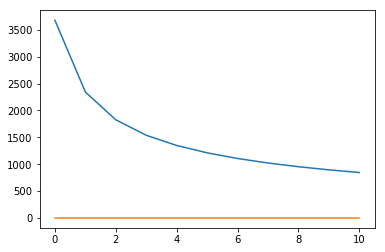

In [153]:
import matplotlib.pyplot as plt
plt.plot(range(len(errors)), np.abs(errors))
plt.plot(range(len(rocs)), rocs)
plt.show()

In [154]:
print errors

[3679.8764865464732, 2344.8945269123101, 1827.095149567826, 1538.9544593461271, 1349.1773753775208, 1211.9775234262563, 1106.7676137235057, 1022.7414519960714, 953.60690300180659, 895.41396831699319, 845.53793181966387]


In [91]:
def MF_model(x, users, songs, b_u, b_m, W, V):
    x = x.split(',')
    user_id, music_id = users.get(x[1], -1), songs.get(x[2], -1)
    interaction = np.dot(W[music], V[:,user_id]) if user_id != -1 and music_id != -1 \
                    else 0
    pred = b_u[user_id] + b_m[music_id] + interaction 
    #return max(min(pred, 1), 0)
    return 1 if pred >= 0.5 else 0
print MF_model(data[2], users, songs, b_u, b_m, W, V)

0


In [95]:
test_data = []
with open('../data/test.csv') as data_file:
    for line in data_file:
        test_data += line,

In [96]:
output = [[int(x.split(',')[0]), \
           MF_model(x, users, songs, b_u, b_m, W, V)] \
          for x in test_data[1:]]

In [ ]:
def evaluate(pred, real):
    pred = [x[1] for x in pred]
    truth = [x[-1] for x in real]
    return np.sum(np.abs(pred - truth))
evaluate(output, data)

In [ ]:
with open('../data/val1/V.pickle', 'wb') as handle:
    pickle.dump(V, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/val1/W.pickle', 'wb') as handle:
    pickle.dump(W, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/val1/b_u.pickle', 'wb') as handle:
    pickle.dump(b_u, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../data/val1/b_m.pickle', 'wb') as handle:
    pickle.dump(b_m, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [88]:
for i in range(5):
    print output[i]

NameError: name 'output' is not defined

In [97]:
with open('../submissions/MF_validat.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar=',', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['id','target'])
    for row in output:
        writer.writerow(row)

In [98]:
print 'done'

done
